In [ ]:
%pip install qiskit[visualization]
%pip install qiskit_aer

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import XGate, YGate, ZGate, CCXGate, HGate, CXGate
import numpy as np

In [3]:
# a = 1 / np.sqrt(2)
# b = 1 / np.sqrt(2)
a = 0.75
b = np.sqrt(1 - a ** 2)
# alpha = 1 / np.sqrt(2)
# beta = 1 / np.sqrt(2)

alpha = 0.8
beta = 0.6

s = 1
t_s = [0, 1, 0]
n = len(t_s)

In [5]:
def i_s(n):
  return np.identity(2 ** n)

o, i = i_s(1)
i_s_n = i_s(n)
i_s_n1 = i_s(n + 1)

tt_s = [o if ti == 0 else i for ti in t_s]
tt_prime_s = [i if ti == 0 else o for ti in t_s]


def rec_kron(*vecs):
  if len(vecs) <= 0: return 1
  curr = vecs[0]
  for vec in vecs[1:]:
    curr = np.kron(curr, vec)
  return curr


# input_state = alpha * np.kron(np.kron(o, tt2), tt1) + ((-1)**s) * beta * np.kron(np.kron(i, (tt2_prime)), tt1_prime)
input_state = alpha * rec_kron(*tt_s) + ((-1) ** s) * beta * rec_kron(*tt_prime_s)
# input_state = alpha * i_s_n[0] + beta * i_s_n[(2 ** n) - 1]

ghz_state = a * i_s_n1[0] + b * i_s_n1[(2 ** (n + 1) - 1)]
# Defining the Phi_i states:
phi1 = a * np.kron(i_s_n[0], o) + b * np.kron(i_s_n[(2 ** n) - 1], i)
phi2 = a * np.kron(i_s_n[0], o) - b * np.kron(i_s_n[(2 ** n) - 1], i)
phi3 = a * np.kron(i_s_n[(2 ** n) - 1], o) + b * np.kron(i_s_n[0], i)
phi4 = a * np.kron(i_s_n[(2 ** n) - 1], o) - b * np.kron(i_s_n[0], i)


phi_cap = np.array([phi1, phi2, phi3, phi4]).T
phi_product = phi_cap @ phi_cap.conj().T
penrose_inverse = np.linalg.pinv(phi_product)

def condi_gate(gate, c):
  return gate if c == 1 else np.identity(2)

# Designing the U_st gate that maps our state from psi_zero to psi_st

only_x_operations = [condi_gate(XGate().to_matrix(), ti) for ti in t_s[1:]]
all_z_and_x_operations = [condi_gate(XGate().to_matrix(), t_s[0]) @ condi_gate(ZGate().to_matrix(), s)] + only_x_operations
U_st = rec_kron(*all_z_and_x_operations)

U_prime = np.kron(U_st, np.identity(2))
f_1 = np.sqrt(2) * np.abs(b) * U_prime @ penrose_inverse @ phi1
f_2 = np.sqrt(2) * np.abs(b) * U_prime @ penrose_inverse @ phi2
f_3 = np.sqrt(2) * np.abs(b) * U_prime @ penrose_inverse @ phi3
f_4 = np.sqrt(2) * np.abs(b) * U_prime @ penrose_inverse @ phi4

F1 = np.outer(f_1, f_1.conj().T)
F2 = np.outer(f_2, f_2.conj().T)
F3 = np.outer(f_3, f_3.conj().T)
F4 = np.outer(f_4, f_4.conj().T)

F0 = np.identity(2 ** (n + 1)) - (F1 + F2 + F3 + F4)
sqrt_F0_t = np.sqrt(np.around(F0, 6)).T
non_zero_sqrt_F0_t = sqrt_F0_t[np.around((sqrt_F0_t), 6).any(axis=1)]

f_s = np.concatenate([[f_1, f_2, f_3, f_4], non_zero_sqrt_F0_t], axis=0)

number_of_povm_bits = n + 1 + (1 if f_s.shape[0] > (2 ** (n + 1)) else 0)

V = np.array([np.outer(a, b.conj().T) for a, b in zip(i_s(number_of_povm_bits)[:f_s.shape[0]], f_s)]).sum(axis=0)

rr = np.random.rand(V.shape[0], V.shape[0] - V.shape[1])
v_s = rr / np.linalg.norm(rr, axis=0)

U_non_orthonormal = np.concatenate([V, v_s], axis=1)

Q, R = np.linalg.qr(U_non_orthonormal, 'complete')
U = Q * np.sign(np.diag(R))

total_qubits = n + number_of_povm_bits
Statevector(input_state).draw('latex')

<IPython.core.display.Latex object>

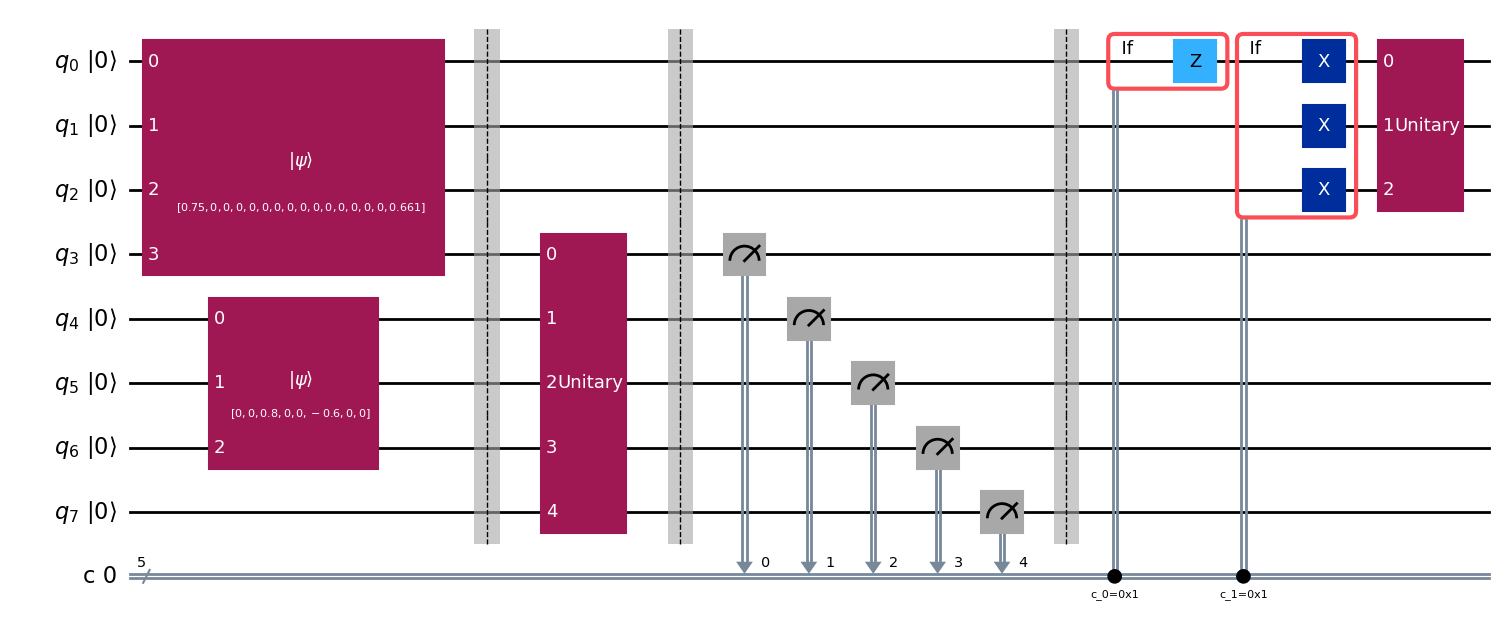

In [6]:
qc = QuantumCircuit(total_qubits, number_of_povm_bits)

qc.initialize(ghz_state, np.arange(0, n + 1, 1).tolist())
qc.initialize(input_state, np.arange(n + 1, n + n + 1, 1).tolist())

qc.barrier()

qc.unitary(U, np.arange(n, total_qubits, 1).tolist())

qc.barrier()

qc.measure(np.arange(n, total_qubits, 1).tolist(), np.arange(0, number_of_povm_bits, 1))

qc.barrier()


# reversed_t_s = [*reversed(t_s)]
# for i in range(n - 1):
#  with qc.if_test((1, 1)):
#    qc.x(i)

# with qc.if_test((1, 1)):
#  qc.x(n - 1)

with qc.if_test((0, 1)):
  qc.z(0)
with qc.if_test((1, 1)):
  qc.x(np.arange(0, n, 1).tolist())

qc.unitary(U_st, np.arange(0, n, 1).tolist())
# qc.measure_all()
qc.draw('mpl', initial_state=True)

In [7]:
aersim = AerSimulator()
qc.save_statevector()
result = aersim.run(qc).result()
sv = result.get_statevector(qc)
# print(sv)
# array_to_latex(sv, max_size = 32)
sv.draw("latex")

<IPython.core.display.Latex object>

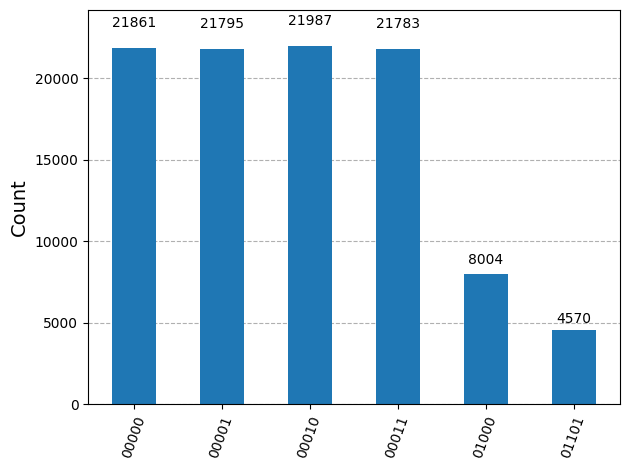

In [8]:
aersim = AerSimulator()
qc = transpile(qc, aersim)
job = aersim.run(qc, shots=100000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)